In [1]:
import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, models, transforms

from torch.utils.data.sampler import SubsetRandomSampler

from torch.utils.data import DataLoader
from torchvision.models import resnet18

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
import seaborn as sns

C:\Users\erudi\anaconda3\envs\torch\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\erudi\anaconda3\envs\torch\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\erudi\anaconda3\envs\torch\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
torch.manual_seed(159)

In [3]:
dataset_path = "./Black_bg"

In [4]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225]) #Normalizing the data to the data that the ResNet18 was trained on
    
])
test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(), 
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225]) #Normalizing the data to the data that the ResNet18 was trained on
    
])

train_test_transform = {'train' : train_transform, 'test': test_transform}

In [5]:
testset = datasets.ImageFolder(dataset_path,       
                    transform=train_test_transform['test'])

In [6]:
def split_image_data(data_path, transform_dict):
    trainset = datasets.ImageFolder(data_path,       
                    transform=transform_dict['train'])
    testset = datasets.ImageFolder(data_path,       
                    transform=transform_dict['test'])
    
    num_test_imgs = int(np.floor(0.20 * len(trainset)))
    idx = list(range(len(trainset)))
    np.random.shuffle(idx)
    
    train_sampler = SubsetRandomSampler(idx[num_test_imgs:])
    test_sampler = SubsetRandomSampler(idx[:num_test_imgs])
    
    trainloader = DataLoader(trainset, sampler=train_sampler, batch_size=5)
    testloader = DataLoader(testset, sampler=test_sampler, batch_size=5)
    
    return trainloader, testloader

In [7]:
trainloader, testloader = split_image_data(dataset_path, train_test_transform)

In [8]:
len(testloader)

73

In [9]:
class_names = ['Healthy', 'Resistant', 'Susceptible']

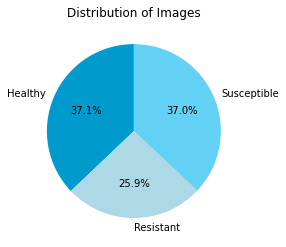

In [10]:
class_names = os.listdir(dataset_path)
image_count = {}
color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9',   
                      '#C1F0F6', '#0099CC']
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(dataset_path,i)))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
plt.title("Distribution of Images")
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=False,
        autopct = '%1.1f%%',
        startangle=90,
       colors=color_palette_list[0:3])
plt.show()

<AxesSubplot:title={'center':'Image count by type'}>

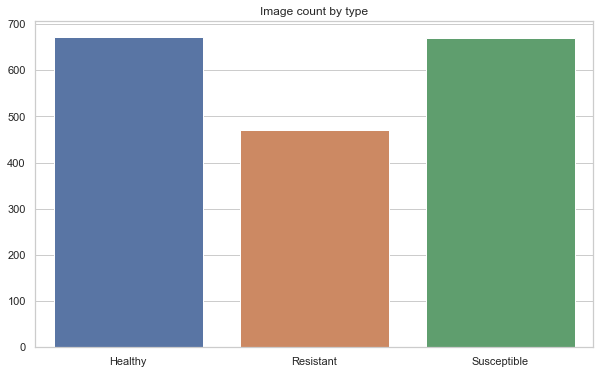

In [11]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,6))
plt.title("Image count by type")
sns.barplot(x=list(image_count.keys()), y=list(image_count.values()))

In [12]:
model = resnet18(pretrained=True)

In [13]:
model.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()

In [14]:
model.load_state_dict(torch.load("comp_watershed.pt"))

<All keys matched successfully>

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

In [17]:
def image_label_plotter(imgs, labels, output_pred):
    plt.figure(figsize=(8,6))
    for i, img in enumerate(imgs):
        plt.subplot(1, 5, i + 1, xticks = [], yticks =[]) 
        img = img.cpu().numpy().transpose((1, 2, 0))
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) #using mean and std
        img = np.clip(img, 0., 1.)
        plt.imshow(img)
        
        col = 'green' if output_pred[i] == labels[i] else 'red'
        xlabel = class_names[int(labels[i].cpu().numpy())]
        ylabel = class_names[int(output_pred[i].cpu().numpy())]
        plt.xlabel(xlabel)
        plt.ylabel(ylabel, color=col)
    plt.tight_layout()
    plt.show()

In [18]:
def display_prediction_images(testloader):
    model.eval() 
    imgs, labels = next(iter(testloader))
    if (torch.cuda.is_available()):
        imgs = imgs.cuda()
        labels = labels.cuda()
    outputs = model(imgs)
    _, output_pred = torch.max(outputs, 1)
    image_label_plotter(imgs, labels, output_pred)



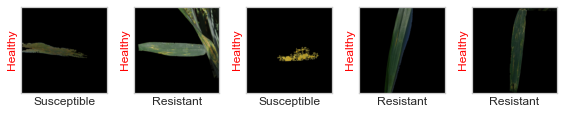

In [18]:
display_prediction_images(testloader)

In [21]:
def train_model(model, epochs, trainloader, testloader, optimizer, loss_fn):
    metrics = {'train_loss' : [], 
               'valid_loss' : [], 
               'train_accuracy' : [], 
               'valid_accuracy' : [], 
               'train_loss_all' : [], 
               'train_acc_all' : []}
    print("Training {} model".format(model.__class__.__name__))
    train_step = 0
    for e in range(0, epochs):
        print()
        print("Epoch {} of {}".format(e+1,epochs))

        train_loss = 0.
        val_loss = 0.  
        
        model.train()
        for batch_no, (images, labels) in enumerate(trainloader):
            if (torch.cuda.is_available()):
                images = images.cuda()
                labels = labels.cuda()
            train_step += 1
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward() #Back propogation
            optimizer.step() 
            train_loss += loss.item() 
            
            _, train_preds = torch.max(outputs, 1) 
            train_acc = sum((train_preds == labels).cpu().numpy())
            
            metrics['train_loss_all'].append(train_loss/(train_step+1))
            metrics['train_acc_all'].append(train_acc /(train_step+1))
            
            #Evaluating the model every 20th batch
            if batch_no % 20 == 0:
                metrics['train_loss'].append(train_loss/(train_step+1))
                metrics['train_accuracy'].append(train_acc/(train_step+1))
                print('Evaluating at Batch', batch_no)

                accuracy = 0

                model.eval()

                for val_step, (images, labels) in enumerate(testloader):
                    if (torch.cuda.is_available()):
                        images = images.cuda()
                        labels = labels.cuda()
                    outputs = model(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1) 
                    accuracy += sum((preds == labels).cpu().numpy()) 

                val_loss /= (val_step + 1) 
                accuracy = accuracy/ (len(testset) / 5)
                print("Validation Loss: {:.4f}, Accuracy: {:.4f}".format(val_loss, accuracy))
                
                metrics['valid_loss'].append(val_loss)
                metrics['valid_accuracy'].append(accuracy)
                
                

                display_prediction_images(testloader)

                model.train()

                if accuracy >= 0.87:
                    
                    print('Optimal Accuracy Attained. Stopping now!')
                    train_loss /= (train_step + 1)
                    print("Training Loss {:.4f}".format(train_loss))
                    return metrics

        

Training ResNet model

Epoch 1 of 1
Evaluating at Batch 0
Validation Loss: 1.1832, Accuracy: 0.3363


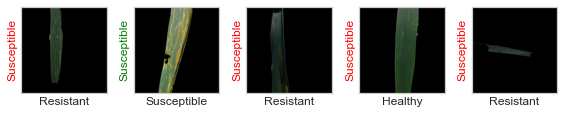

Evaluating at Batch 20
Validation Loss: 0.7294, Accuracy: 0.7470


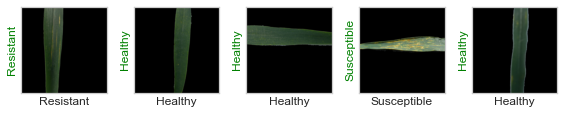

Evaluating at Batch 40
Validation Loss: 0.4999, Accuracy: 0.7911


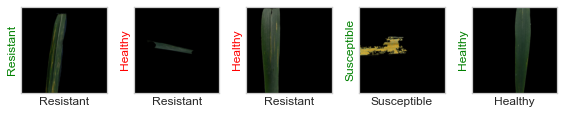

Evaluating at Batch 60
Validation Loss: 0.4099, Accuracy: 0.8324


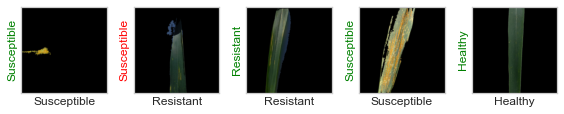

Evaluating at Batch 80
Validation Loss: 0.3560, Accuracy: 0.8655


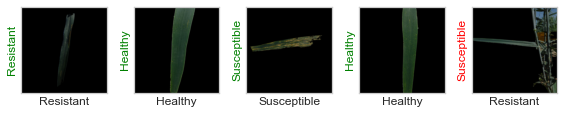

Evaluating at Batch 100
Validation Loss: 0.3489, Accuracy: 0.8490


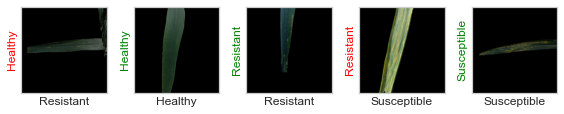

Evaluating at Batch 120
Validation Loss: 0.3108, Accuracy: 0.8793


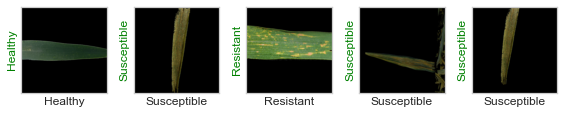

Optimal Accuracy Attained. Stopping now!
Training Loss 0.6203


In [28]:
metrics = train_model(model, 1, trainloader, testloader, optimizer, loss_fn)

In [29]:
torch.save(model.state_dict(), "comp_watershed.pt")

In [19]:
def test_model(testloader, model, loss_fn):
    print("Testing {} model".format(model.__class__.__name__))
    test_metrics = {'labels' : [], 
                    'predictions' :[]}
    test_loss = 0.
    correct = 0.
    total = 0.
    model.eval()
    for batch_idx, (images, target) in enumerate(testloader):
        if (torch.cuda.is_available()):
            images = images.cuda()
            target = target.cuda()
        test_metrics['labels'] += list(target)
        outputs = model(images)
        loss = loss_fn(outputs, target)
        # update average test loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = outputs.data.max(1, keepdim=True)[1]
        
        test_metrics['predictions'] += list(pred)
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += images.size(0)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %.3f%% (%2d/%2d)' % (100. * correct / total, correct, total))
    return test_metrics

In [20]:
test_metrics = test_model(testloader, model, loss_fn)

Testing ResNet model


C:\Users\erudi\anaconda3\envs\torch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Test Loss: 0.343636


Test Accuracy: 85.083% (308/362)


In [21]:
import pickle

with open('comp/watershed_test_metrics.obj', 'wb') as fp:
    pickle.dump(test_metrics, fp)

In [22]:
labs = [int(x) for x in test_metrics['labels']]
preds = [int(x) for x in test_metrics['predictions']]

In [23]:
with open('comp/watershed_labels.obj', 'wb') as fp:
    pickle.dump(labs, fp)
    
with open('comp/watershed_preds.obj', 'wb') as fp:
    pickle.dump(preds, fp)

In [24]:
class_names

['Healthy', 'Resistant', 'Susceptible']

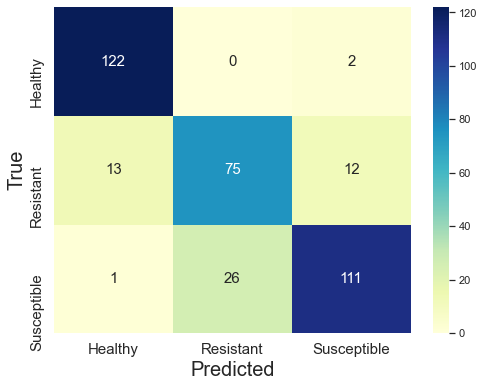

In [25]:
confusion_mat =  confusion_matrix(labs, preds)
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(confusion_mat,cmap="YlGnBu", annot=True, fmt='g', ax=ax, annot_kws = {'size':15})

#plt.figure(figsize=(8,6))
ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);

#plt.title("Confusion Matrix for Watershed Dataset", fontsize=20)
#plt.xticks([0,1,2],labels=class_names)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('True', fontsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15) 

plt.savefig("watershed_confusion.png")
plt.show()

In [26]:
len(labs)

362

In [27]:
print(classification_report(labs, preds))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       124
           1       0.74      0.75      0.75       100
           2       0.89      0.80      0.84       138

    accuracy                           0.85       362
   macro avg       0.84      0.85      0.84       362
weighted avg       0.85      0.85      0.85       362



In [28]:
import sklearn
from sklearn.metrics import roc_curve, RocCurveDisplay, auc

In [29]:
fpr, tpr, thresholds = roc_curve(labs, preds, pos_label=2)

In [30]:
roc_auc = auc(fpr, tpr)

In [32]:
roc_auc

0.9264848602484471

<Figure size 864x576 with 0 Axes>

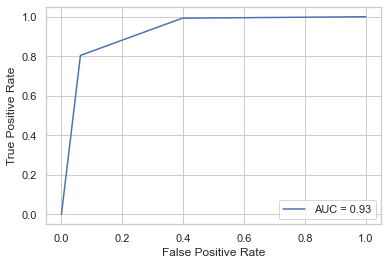

In [31]:
roc_fig = plt.figure(figsize=(12,8))
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
#plt.figure(figsize=(12,8))
plt.savefig('comp/watershed_roc_plot.png')
plt.show()